In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'world-cup-penalty-shootouts:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F819475%2F1402138%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240625%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240625T123959Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D890973ed1e01c939636cda892874029ee60be2a11a2101378d6d7981b5873ceeb5f3319a86a1ab1001acc293aa5e6ebb0efa2388665fc4338f332c9463c283a8ae9f0144c59773e8061382791caf265ea96455b2f91a146803b398fa0ce532e12f9fef0a058db122e39feb86bde5c2bf55a67d4bc6d9f777af2dd4d63120d84ec585b6469f679bebfa5c03ddbd8cec2c9d88f4c7328cdaa38a79e98cdd62f4c1f9d08d852b524c33e5a6ee2b6b4fbfcb6e970f7f8777912672d743908c9699442608ca71cae71ee4199051cbc3095aff178c75c200eb9edd12691ce8e18a7edb35eb4a5ca1a400b558f4a587c1ca440b92ff99b4daa2b8c1642cf19fba48ef6f,world-cup-penalty-shootouts-2022:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2758874%2F4785767%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240625%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240625T123959Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1b4fc30f78ccff4a07681e258c6901d608f2a6e8e4ac11dd436d9633ffc3091c4011dcafd0dd4057134edbbbe4af260f7481e93967eef909a11b771f5f07e9ece92af7c50af949c678057c77b0f4b0c087060eb157d406e35cf493a6c47d68ca8f30c680c0aa9f76c79d4b29f502c8407d8ecfa662fff556dd68df00eaa1632d54b4119a2703505a6d0e1cfc76f1aae0031a19ae6fe2c990797da92ddbf99ca422da48d69a39c0a1f898d31a66e842d4e751061d52fe56b65ae3a52447554708c0a94474f4d154820738c1d53483c43def5e798719c1b4bf93e54f4e072af6dccc025a3f3866a6a7bacebc0f2f71d0517279f9f2d0e2f42d8d3e2326a2bf5d21'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1764 bytes downloaded
Downloaded and uncompressed: world-cup-penalty-shootouts
[==================================================] 1870 bytes downloaded
Downloaded and uncompressed: world-cup-penalty-shootouts-2022
Data source import complete.


*In this notebook, I'll try to analyze common things that happen in penalty shooutouts, using data from the world cup from 1982 to 2022*

# 1. Importing libraries and data

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/world-cup-penalty-shootouts/WorldCupShootouts.csv
/kaggle/input/world-cup-penalty-shootouts-2022/WorldCupShootouts.csv


In [3]:
df = pd.read_csv('/kaggle/input/world-cup-penalty-shootouts-2022/WorldCupShootouts.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Game_id         320 non-null    int64 
 1   Team            320 non-null    object
 2   Zone            320 non-null    int64 
 3   Foot            320 non-null    object
 4   Keeper          320 non-null    object
 5   OnTarget        320 non-null    int64 
 6   Goal            320 non-null    int64 
 7   Penalty_Number  320 non-null    int64 
 8   Elimination     320 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 22.6+ KB


We see we got 9 columns of data and all of them don't contain null values.

In [4]:
df.head(10)

,Game_id,Team,Zone,Foot,Keeper,OnTarget,Goal,Penalty_Number,Elimination
0,1,FRA,7,R,R,1,1,1,0
1,1,GER,9,R,C,1,1,2,0
2,1,FRA,6,R,L,1,1,3,0
3,1,GER,2,R,C,1,1,4,0
4,1,FRA,9,R,L,1,1,5,0
5,1,GER,4,R,L,1,0,6,0
6,1,FRA,8,L,L,1,0,7,0
7,1,GER,3,R,R,1,1,8,0
8,1,FRA,9,R,L,1,1,9,0
9,1,GER,9,R,C,1,1,10,1


As we can see in the data there is a zone column which for reference is divided in
1. Upper left corner
2. Upper center
3. Upper right corner
4. Middle left area
5. Middle center area
6. Middle right area
7. Bottom left corner
8. Bottom center zone
9. Bottom right corner

# 2 Data Exploration


# 2.1 Most Preferred Foot and Preferences
*In this part I want to see which way right and left footed players choose to go.But first let's define another column 'Area' that will be like this*
1. Left
2. Middle
3. Right

In [5]:
def get_area(zone):
    if zone == 1 or zone == 4 or zone == 7:
        return 1
    elif zone == 2 or zone == 5 or zone == 8:
        return 2
    elif zone == 3 or zone == 6 or zone == 9:
        return 3

df['Area'] = df['Zone'].apply(get_area)
df

,Game_id,Team,Zone,Foot,Keeper,OnTarget,Goal,Penalty_Number,Elimination,Area
0,1,FRA,7,R,R,1,1,1,0,1
1,1,GER,9,R,C,1,1,2,0,3
2,1,FRA,6,R,L,1,1,3,0,3
3,1,GER,2,R,C,1,1,4,0,2
4,1,FRA,9,R,L,1,1,5,0,3
...,...,...,...,...,...,...,...,...,...,...
315,35,ARG,8,L,R,1,1,4,0,2
316,35,FRA,7,R,L,0,0,5,0,1
317,35,ARG,7,R,L,1,1,6,0,1
318,35,FRA,2,R,L,1,1,7,0,2


Now let's see which area left and right footed players prefer to shoot.

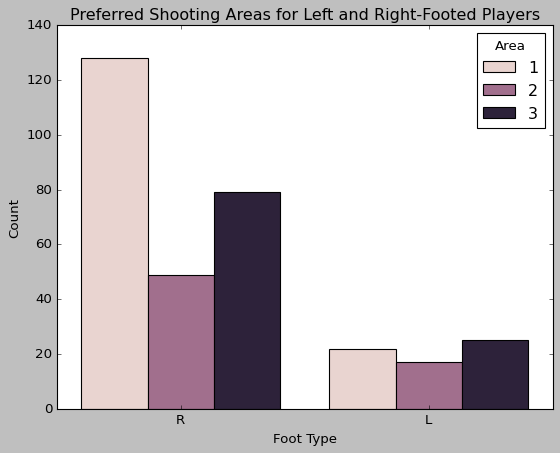

In [16]:
sns.countplot(x='Foot', hue='Area', data=df)
plt.xlabel('Foot Type')
plt.ylabel('Count')
plt.title('Preferred Shooting Areas for Left and Right-Footed Players')
plt.legend(title='Area')
plt.show()

As expected, right shooters tend to go left more and left shooters,even if slightly, tend to prefer going to the right since it's easier to go left if you're right footed and right if you're left footed.

# 2.2 Most likely to score areas.

Now let's give a look to where it's more likely to score a goal first looking at the areas and then at the specific zones.

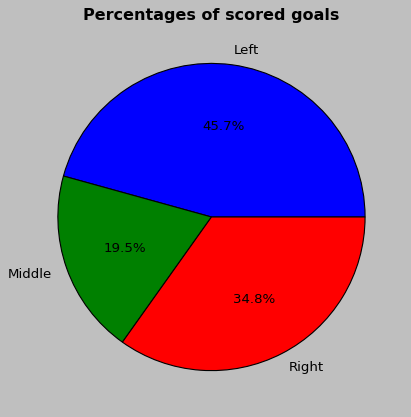

In [7]:
goals = df[df['Goal'] == 1].groupby('Area').size()
non_goals = df[df['Goal'] != 1].groupby('Area').size()

plt.style.use('classic')

goal_labels = ['Left', 'Middle', 'Right']
plt.pie(goals, labels = goal_labels, autopct = "%1.1f%%")
plt.title('Percentages of scored goals', fontweight='bold')
plt.show()

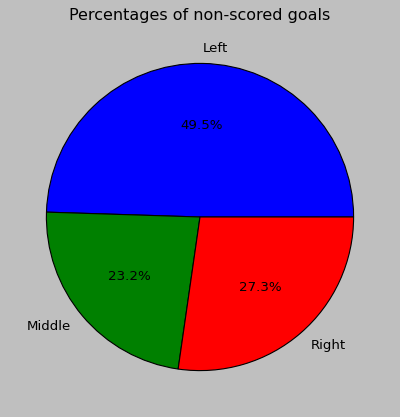

In [8]:
goal_labels = ['Left', 'Middle', 'Right']

plt.pie(non_goals, labels = goal_labels, autopct = "%1.1f%%")
plt.title('Percentages of non-scored goals')
plt.show()

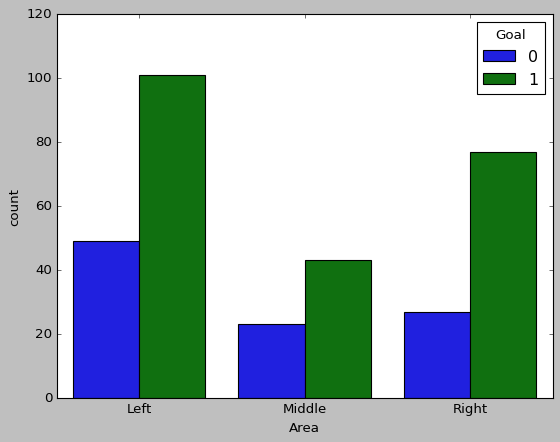

In [9]:
sns.countplot(x = 'Area', data = df, hue = 'Goal')
plt.xticks(range(len(goal_labels)), goal_labels)

plt.show()

*We can see that missed penalties in the middle are almost the same of the ones shot on the right, even though there are a lot less penalties shot in the middle.*

*Finally , left is at the same time the place it's most likely to score, but also the place where it's most likely to miss a penalty.*

*Does this mean the goalkeepers also tend to jump there most of the time?
Let's look if this is true with this remainder:*
>
Looking at it from the shooter's perspective:
* L = the keeper dived to the left.
* C = the keeper kept in the middle of the goal.
* R = the keeper dived to the right.

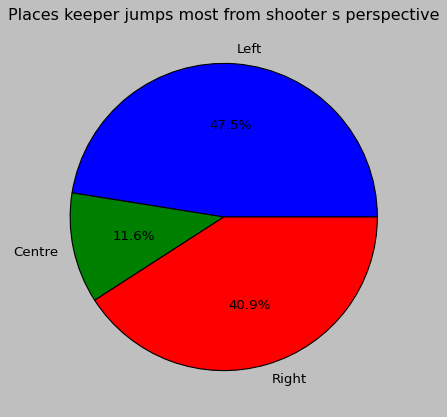

In [10]:
l = df.loc[df['Keeper'] == 'L'].shape[0]
c = df.loc[df['Keeper'] == 'C'].shape[0]
r = df.loc[df['Keeper'] == 'R'].shape[0]

plt.style.use('fast')
places = [l,c,r]
xaxis = ['Left','Centre','Right']
plt.title('Places keeper jumps most from shooter s perspective')
plt.pie(places, labels = xaxis, autopct = '%1.1f%%')


plt.show()

*As expected, keepers tend to jump left more, and we can also see that only 1/10 times keepers stand still on a penalty,most likely because they don't want to look bad in a penalty shootout, but also because less penalties are shot in the middle.*

# 2.3 Most likely to score zones

Now, let's get more specific and find which zones are the most difficult to reach for keepers and where players score the most in penalties.

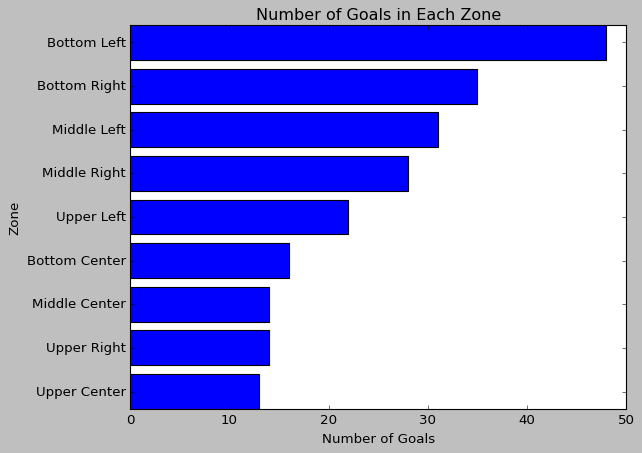

In [11]:
zone_goals = df[df['Goal'] == 1].groupby('Zone').size()
sorted_zone_goals = zone_goals.sort_values(ascending=True)
zone_map = {1: 'Upper Left', 2: 'Upper Center', 3: 'Upper Right',
            4: 'Middle Left', 5: 'Middle Center', 6: 'Middle Right',
            7: 'Bottom Left', 8: 'Bottom Center', 9: 'Bottom Right'}

sorted_zone_labels = [zone_map[zone] for zone in sorted_zone_goals.index]
plt.barh(sorted_zone_labels, sorted_zone_goals.values)
plt.xlabel('Number of Goals')
plt.ylabel('Zone')
plt.title('Number of Goals in Each Zone')
plt.show()


As we could expect, most goals come from bottom left and bottom right cornners, them being the easier to shoot at without missing, while upper right and upper center are at the lowest, them being the hardest to shoot at without missing.

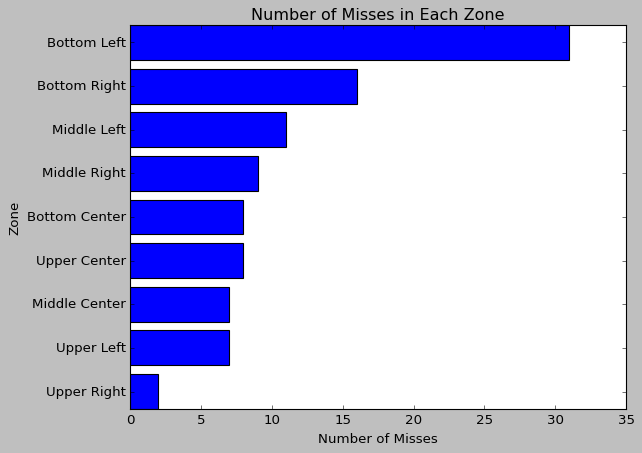

Zone
1     7
2     8
3     2
4    11
5     7
6     9
7    31
8     8
9    16
dtype: int64

In [12]:
zone_miss = df[(df['Goal'] == 0)].groupby('Zone').size()
sorted_zone_miss = zone_miss.sort_values(ascending=True)


sorted_zone_labels2 = [zone_map[zone] for zone in sorted_zone_miss.index]
plt.barh(sorted_zone_labels2, sorted_zone_miss.values)
plt.xlabel('Number of Misses')
plt.ylabel('Zone')
plt.title('Number of Misses in Each Zone')
plt.show()
zone_miss

The data looks pretty much the same for missed penalties, with bottom left and bottom right corners the places where most penalties are missed and the upper corners the ones with fewer goals missed.

In [13]:
df.head(10)

,Game_id,Team,Zone,Foot,Keeper,OnTarget,Goal,Penalty_Number,Elimination,Area
0,1,FRA,7,R,R,1,1,1,0,1
1,1,GER,9,R,C,1,1,2,0,3
2,1,FRA,6,R,L,1,1,3,0,3
3,1,GER,2,R,C,1,1,4,0,2
4,1,FRA,9,R,L,1,1,5,0,3
5,1,GER,4,R,L,1,0,6,0,1
6,1,FRA,8,L,L,1,0,7,0,2
7,1,GER,3,R,R,1,1,8,0,3
8,1,FRA,9,R,L,1,1,9,0,3
9,1,GER,9,R,C,1,1,10,1,3


# 2.4 Penalty number analysis

*Now, let's check which penalty number is scored more and which one is missed more, expecting the first ones to be scored more and the 4th/5th to be scored less.*

In [14]:
df['Penalty_Number'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

We have data until the 12th penalty.

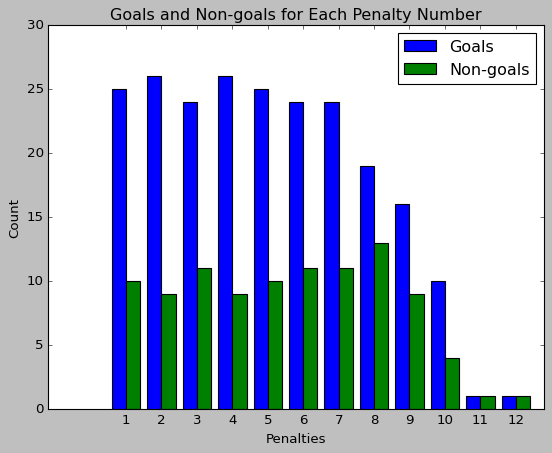

In [15]:
goals = []
for num in range(1,13):
    goals.append(df.loc[(df['Penalty_Number'] == num)&(df['Goal'] == 1)].shape[0])

nongoals = []

for num in range(1,13):
    nongoals.append(df.loc[(df['Penalty_Number'] == num)&(df['Goal'] == 0)].shape[0])

labels = range(1, 13)

bar_width = 0.40
index = np.arange(len(labels))

plt.bar(index, goals, width=bar_width, label='Goals')
plt.bar(index + bar_width, nongoals, width=bar_width, label='Non-goals')

plt.xlabel('Penalties')
plt.ylabel('Count')
plt.title('Goals and Non-goals for Each Penalty Number')
plt.xticks(index + bar_width / 2, labels)
plt.legend()
plt.show()

From what we can see, the 2nd and the 4th penalty are the ones scored the most, maybe because there is not much pressure as there would be for the first penalty in one case, and not being the last in the other case.

We can see this is true because the 1st and 5th missed penalties count is higher than the 2nd and 4th count, with the 3rd penalty actually being the higher when penalties dont go over 5.

When after 5 penalties it is a draw, it gets slightly more likely to miss from the 6th to the 8th penalty where most penalties are missed.

# 3. Conclusions

*Some key facts we can extract from this analysis are :*

1. Right and left footed players tend to shoot diagonally more than they shoot in their foot area.

2. Most penalties are shot on the left, with 50% times scored and 50% missed , while it's interesting that shooting in the middle is the one that might has less chance to score and more to miss.

3. Only 1 out of 10 times keepers tend to stand still on penalties, with more leaning towards the left of the shooter's perspective and actually 7% more than the right, confirming the fact that most penalties are shot on the left so of course keepers will jump that way more.

4. Bottom left and right areas are the ones where the ball is shot most. This comes from the fact that players try to displace the keepers more than trying to shoot by power in the upper and right spots of the goal.

5. There's less pressure if you shoot 2nd or 4th, while more if you shoot 1st, 3rd or 5th. So it would be more optimal to make your top three players shoot the 1st, 3rd and 5th penalty, preferring the best to start first.

6. From the 6th penalty to the 8th there is an increment in missed penalties due to the lesser skill of the players because defenders and not attacking players have to shoot.

Thank you for reading!